In [1]:
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from pyia import GaiaData
from dustmaps.planck import PlanckGNILCQuery

import scipy.interpolate as si
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter

In [2]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc,
    galcen_v_sun=[8.4, 251.8, 8.4] * u.km/u.s
)
with open('../data/galcen_frame.pkl', 'wb') as f:
    pickle.dump(galcen_frame, f)

In [3]:
gaia = at.Table.read('../data/gd1-dr3-polygon.fits')
ps1 = at.Table.read('../data/PS1-DR2_GD1-DR3_xm.fits')
joined = at.join(gaia, ps1, keys='source_id')
joined = at.unique(joined, keys='source_id')
g = GaiaData(joined)

In [4]:
c = g.get_skycoord(distance=False, radial_velocity=False)
c_gd1 = c.transform_to(gc.GD1Koposov10())

Extinction-corrected PS1 photometry

In [5]:
ebv = g.get_ebv(PlanckGNILCQuery)

Ag = 3.172 * ebv
Ar = 2.271 * ebv
Ai = 1.682 * ebv
g0 = g.gMeanPSFMag - Ag
r0 = g.rMeanPSFMag - Ar
i0 = g.iMeanPSFMag - Ai
g.data['g0'] = g0
g.data['r0'] = r0
g.data['i0'] = i0

In [6]:
len(g)

7777242

# Initializations


## Sky track

Previous sky track from: https://adrian.pw/blog/flexible-density-model-jax/

In [7]:
sky_track_data = at.Table.read('../data/dr2/dr2-sky-track.fits')
phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    sky_track_data['phi2'], 
    k=3
)

ln_std_phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    sky_track_data['ln_std_phi2'], 
    k=3
)

In [8]:
spur_box_mask = (
    (c_gd1.phi1 > -42*u.deg) &
    (c_gd1.phi1 < -24*u.deg) &
    (c_gd1.phi2 < 2.2*u.deg) &
    (c_gd1.phi2 > 0*u.deg)
)

std = np.exp(ln_std_phi2_spl(c_gd1.phi1.degree))
sky_track_mask = (
    (np.abs(c_gd1.phi2.degree - phi2_spl(c_gd1.phi1.degree)) < 3 * std)
)

## Distance track

Distance modulus de Boer et al. 2020:
$$
\textrm{DM}(\phi_1) = 15.001 + 2.421\times10^{-2}\,\phi_1 + 2.410\times10^{-4}\phi_1^2
$$

In [9]:
# distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])

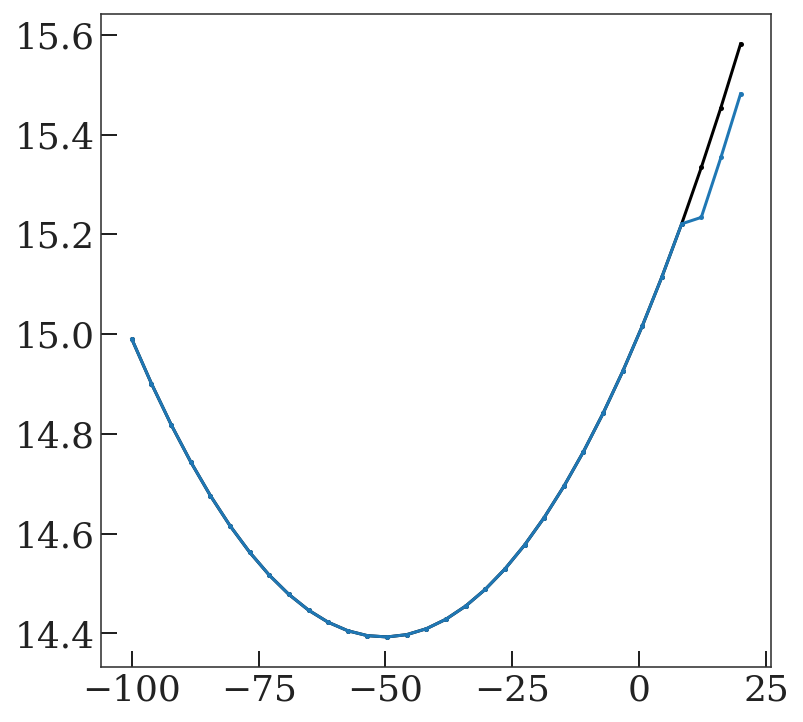

In [10]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])

_grid = np.linspace(-100, 20, 32)
plt.plot(_grid, distmod_spl(_grid))

_shit = distmod_spl(_grid)
_shit[_grid > 10] -= 0.1
plt.plot(_grid, _shit)

distmod_spl = si.InterpolatedUnivariateSpline(_grid, _shit, k=3)

## Rough proper motion box

In [11]:
d_tmp = coord.Distance(distmod=distmod_spl(c_gd1.phi1.degree))
c_tmp = g.get_skycoord(distance=d_tmp, radial_velocity=0*u.km/u.s)
c_gd1_refl = gc.reflex_correct(
    c_tmp.transform_to(gc.GD1Koposov10()),
    galactocentric_frame=galcen_frame
)
g.data['rough_distmod'] = d_tmp.distmod

In [12]:
_pm1_lim = [-9, -3.] * u.mas/u.yr
_pm2_lim = [-1.5, 1.2] * u.mas/u.yr
rough_pm_mask = (
    (c_gd1_refl.pm_phi1_cosphi2 > _pm1_lim.min()) &
    (c_gd1_refl.pm_phi1_cosphi2 < _pm1_lim.max()) &
    (c_gd1_refl.pm_phi2 > _pm2_lim.min()) &
    (c_gd1_refl.pm_phi2 < _pm2_lim.max())
)

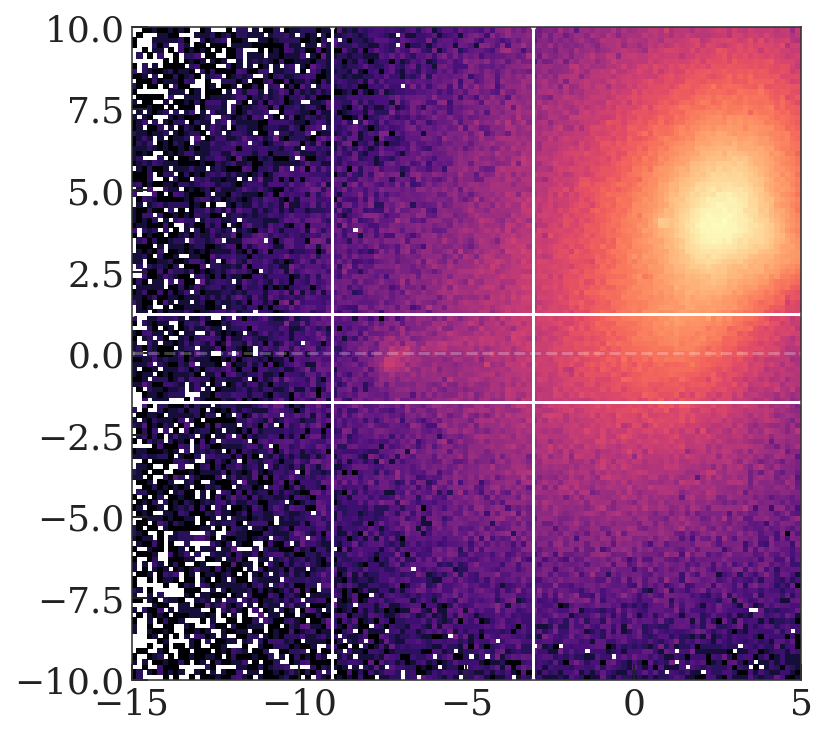

In [13]:
c_gd1_refl = gc.reflex_correct(
    c_tmp.transform_to(gc.GD1Koposov10()),
    galactocentric_frame=galcen_frame
)

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    c_gd1_refl.pm_phi1_cosphi2.value[sky_track_mask],
    c_gd1_refl.pm_phi2.value[sky_track_mask],
    bins=(np.linspace(-15, 5, 128),
          np.linspace(-10, 10, 128)),
    norm=mpl.colors.LogNorm()
)
ax.axhline(0., color='w', ls='--', alpha=0.25)
for xx in _pm1_lim:
    ax.axvline(xx.value, color='w')
for xx in _pm2_lim:
    ax.axhline(xx.value, color='w')

## C(A)MD

In [14]:
mask = (
    sky_track_mask &
    rough_pm_mask
)

gi0 = g0 - i0
Mr0 = r0 - d_tmp.distmod.value

H, xe, ye = np.histogram2d(
    gi0[mask],
    Mr0[mask],
    bins=(
        np.linspace(-1, 1., 151),
        np.linspace(-4, 7, 151)
    )
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

/tmp/ipykernel_1172143/2788309629.py:3: RuntimeWarning: invalid value encountered in true_divide
  sub = H_smoo / H_smoo.sum(axis=0)


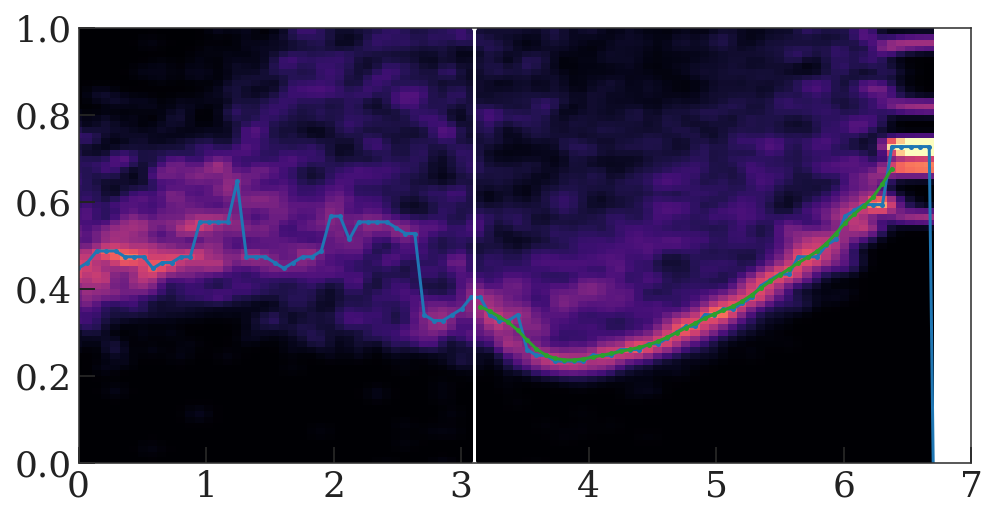

In [15]:
H /= H.max()
H_smoo = gaussian_filter(H, 1)
sub = H_smoo / H_smoo.sum(axis=0)

plt.figure(figsize=(8, 4))
plt.pcolormesh(ye, xe, sub, vmax=0.1)
plt.plot(yc, xc[sub.argmax(axis=0)], color='tab:blue')
plt.xlim(0, 7)
plt.ylim(0, 1)
plt.axvline(3.1, color='w')

ms_gi_track, ms_r_track = xc[sub.argmax(axis=0)], yc
ms_gi_track = gaussian_filter(ms_gi_track, sigma=1.5)

ms_mask = (ms_r_track > 3.1) & (ms_gi_track < 0.8) & (ms_r_track < 6.4)
ms_gi_track = ms_gi_track[ms_mask]
ms_r_track = ms_r_track[ms_mask]

plt.plot(ms_r_track, ms_gi_track, color='tab:green')

ms_r_gi_spl = si.InterpolatedUnivariateSpline(
    ms_r_track[np.argsort(ms_r_track)],
    ms_gi_track[np.argsort(ms_r_track)],
    k=3, 
    ext=1
)

(-0.25, 0.25)

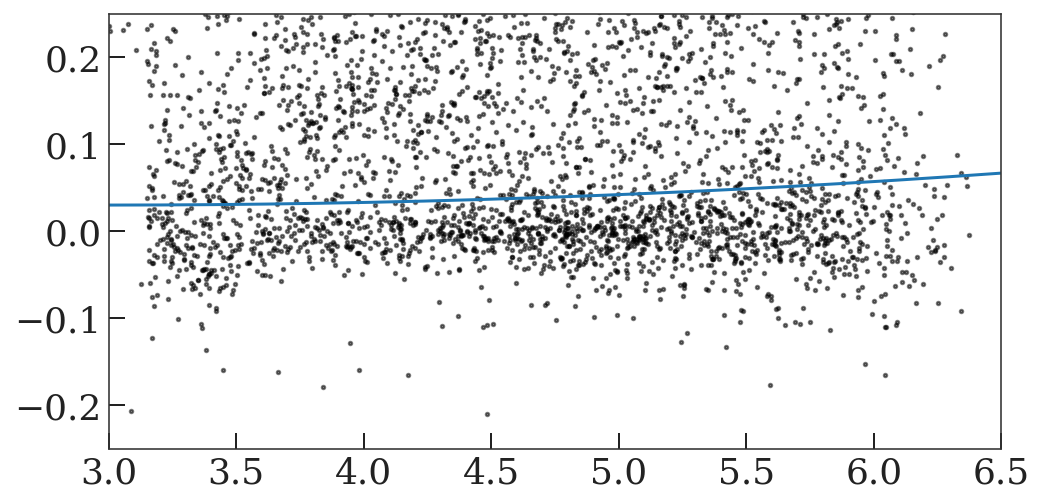

In [16]:
tmp_mask = np.abs((gi0 - ms_r_gi_spl(Mr0))) < 0.1

plt.figure(figsize=(8, 4))
plt.scatter(
    Mr0[mask], 
    (gi0 - ms_r_gi_spl(Mr0))[mask],
    s=3,
    alpha=0.5
)

_grid = np.linspace(3, 6.5, 256)
cmd_width_spl = np.poly1d([3e-3, 0, 0.03])
plt.plot(_grid, cmd_width_spl(_grid - 3), marker='', color='tab:blue')

plt.xlim(3, 6.5)
plt.ylim(-0.25, 0.25)

(7.0, -4.0)

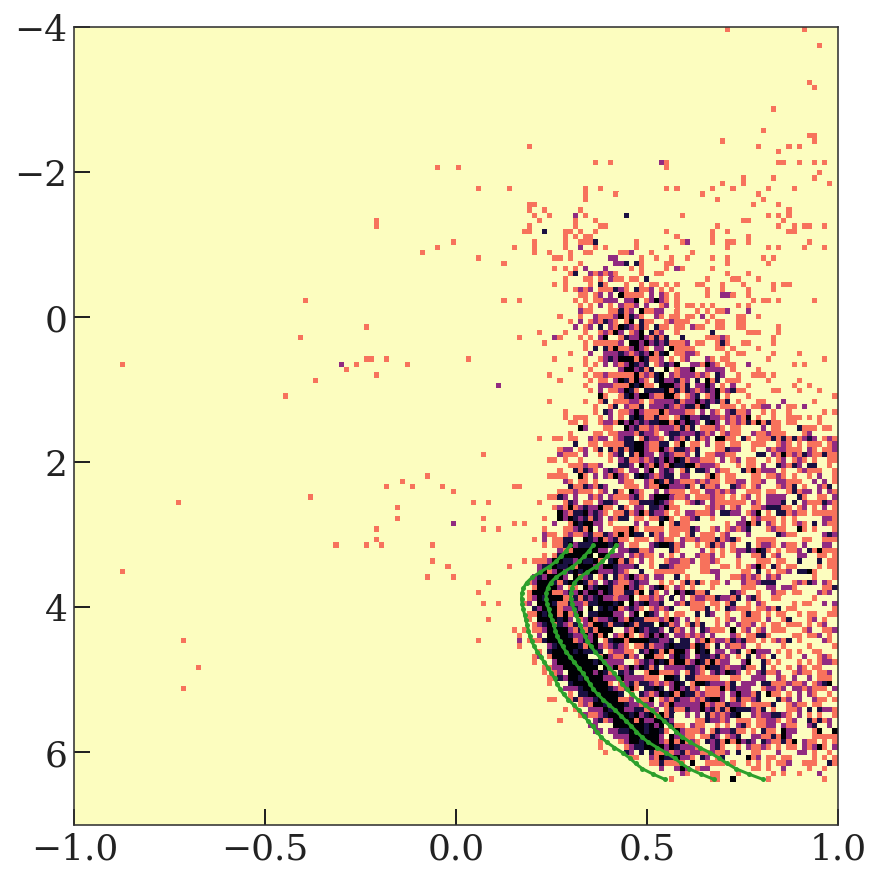

In [17]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

# H /= H.sum(axis=0)
# H /= H.sum(axis=1)[:, None]
H /= H.max()

ax.pcolormesh(
    xe, 
    ye, 
    H.T,
    cmap='magma_r',
    vmin=0, vmax=0.2
)

ax.plot(ms_gi_track, ms_r_track, color='tab:green')
ax.plot(ms_gi_track + 2 * cmd_width_spl(ms_r_track - 3.), ms_r_track, color='tab:green')
ax.plot(ms_gi_track - 2 * cmd_width_spl(ms_r_track - 3.), ms_r_track, color='tab:green')

ax.set_ylim(ax.get_ylim()[::-1])

In [18]:
_x = np.concatenate((
    ms_gi_track - 3 * cmd_width_spl(ms_r_track - 3.),
    ms_gi_track[::-1][1:] + 3 * cmd_width_spl(ms_r_track[::-1][1:] - 3.)
))
_y = np.concatenate((ms_r_track, ms_r_track[::-1][1:]))
cmd_ms_path = mpl.path.Path(np.stack((_x, _y)).T)

girX = np.stack((gi0, Mr0)).T
cmd_ms_mask = cmd_ms_path.contains_points(girX)
cmd_ms_mask.sum()

685767

## BHB and BS

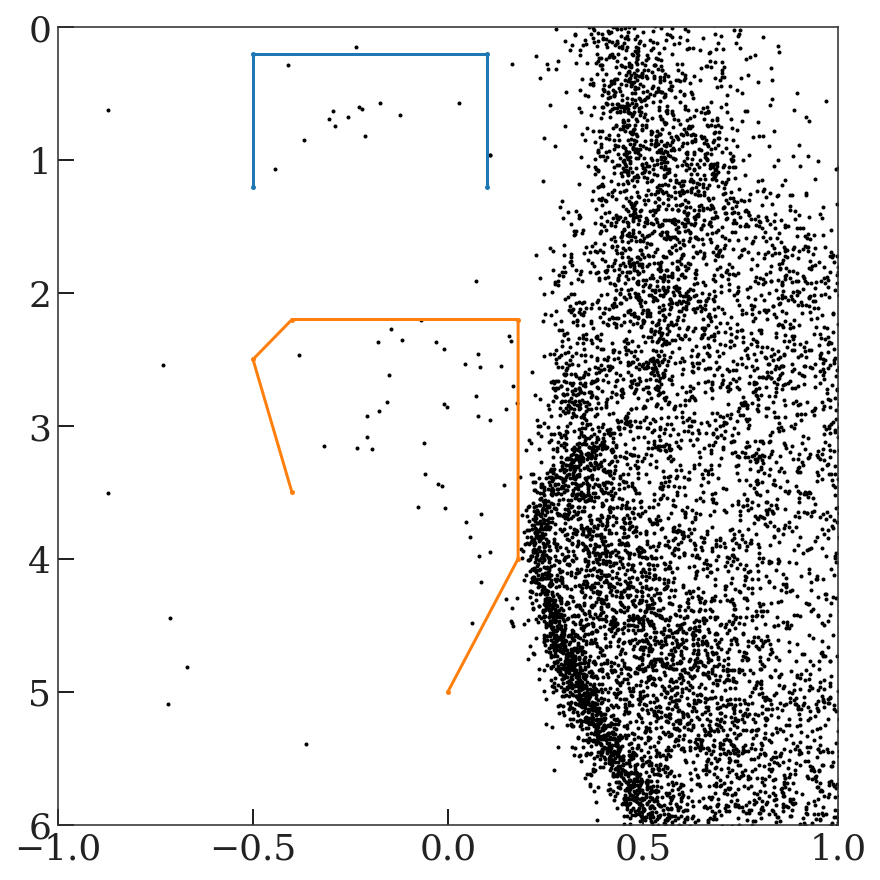

In [20]:
mask = (sky_track_mask | spur_box_mask) & rough_pm_mask

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

ax.plot(
    gi0[mask],
    Mr0[mask], 
    marker='o',
    ms=2., 
    ls='none'
)
ax.set_xlim(-1, 1)
ax.set_ylim(6, 0)

bhb_nodes = np.array([
    [-0.5, 1.2],
    [-0.5, 0.2],
    [0.1, 0.2],
    [0.1, 1.2]
])
ax.plot(bhb_nodes[:, 0], bhb_nodes[:, 1])

bs_nodes = np.array([
    [-0.4, 3.5],
    [-0.5, 2.5],
    [-0.4, 2.2],
    [0.18, 2.2],
    [0.18, 4],
    [0.0, 5.],
#     [-0.4, 2.2],
])
ax.plot(bs_nodes[:, 0], bs_nodes[:, 1])

cmd_bhb_mask = mpl.path.Path(bhb_nodes).contains_points(girX)
cmd_bs_mask = mpl.path.Path(bs_nodes).contains_points(girX)

In [21]:
mask_tbl = at.Table()
mask_tbl['sky_track'] = sky_track_mask
mask_tbl['spur_box'] = spur_box_mask
mask_tbl['pm_rough'] = rough_pm_mask
mask_tbl['cmd_ms'] = cmd_ms_mask
mask_tbl['cmd_bs'] = cmd_bs_mask
mask_tbl['cmd_bhb'] = cmd_bhb_mask
mask_tbl.write('../cache/init-masks.fits', overwrite=True)

(-10.0, 5.0)

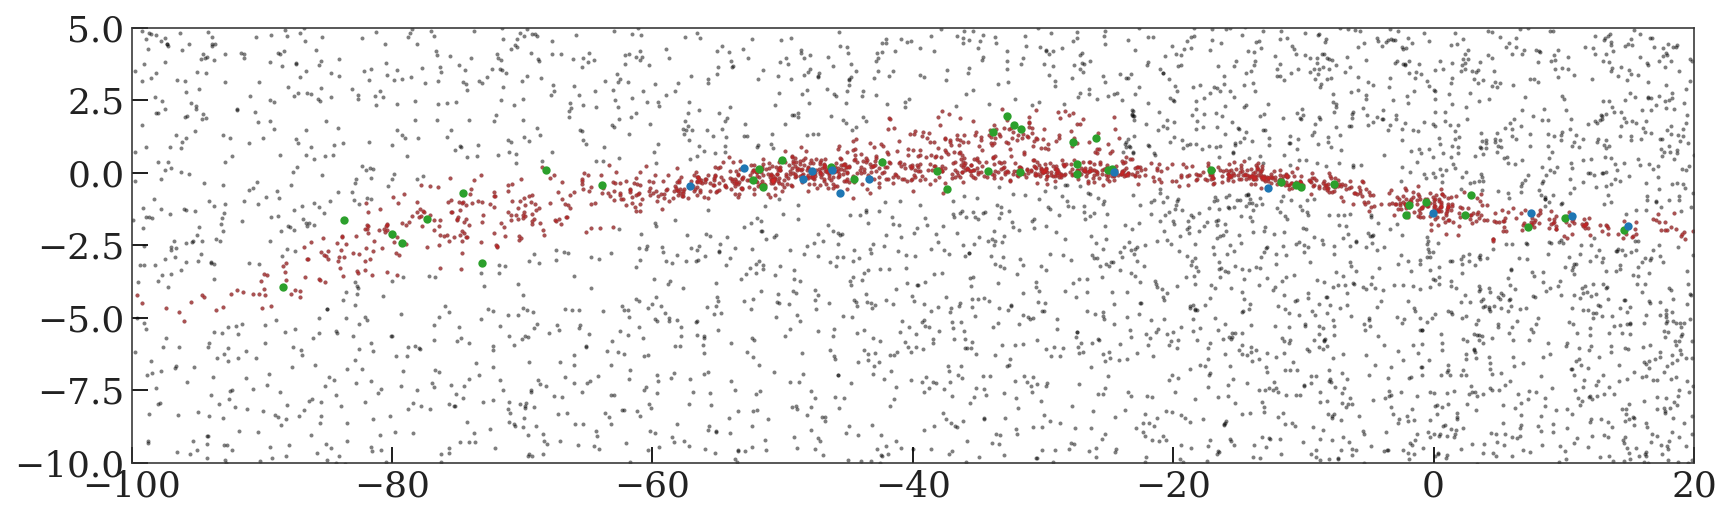

In [34]:
mask = mask_tbl['pm_rough'] & mask_tbl['cmd_ms']

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    ls='none',
    marker='o',
    mew=0,
    ms=2,
    alpha=0.5
);

ax.plot(
    c_gd1.phi1.degree[mask & (sky_track_mask | spur_box_mask)],
    c_gd1.phi2.degree[mask & (sky_track_mask | spur_box_mask)],
    ls='none',
    marker='o',
    mew=0,
    ms=2,
    alpha=0.5,
    color='tab:red'
);


mask = mask_tbl['pm_rough'] & mask_tbl['cmd_bs'] & (sky_track_mask | spur_box_mask)
ax.scatter(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    marker='o',
    s=10,
    color='tab:green',
    zorder=100
);

mask = mask_tbl['pm_rough'] & mask_tbl['cmd_bhb'] & (sky_track_mask | spur_box_mask)
ax.scatter(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    marker='o',
    s=10,
    color='tab:blue',
    zorder=100
);

# ax.axvline(-42)
# ax.axvline(-28)
# ax.axhline(2.2)
# ax.axhline(0)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [23]:
g.data.write('../data/gd1-GaiaDR3-PS1DR2-joined.fits', overwrite=True)

---

Check that previous RRL/BHB identified are in the sample:

- RRL stars from: https://users.flatironinstitute.org/~apricewhelan/data/misc/gd1-dr2/gd1-RRL.fits
- BHB stars from: https://users.flatironinstitute.org/~apricewhelan/data/misc/gd1-dr2/gd1-BHB.fits

In [24]:
dr2_bhb = GaiaData('../data/dr2/dr2-gd1-BHB.fits')
dr2_rrl = GaiaData('../data/dr2/dr2-gd1-RRL.fits')
dr2_bhb_c = dr2_bhb.get_skycoord(distance=False)
dr2_rrl_c = dr2_rrl.get_skycoord(distance=False)

In [25]:
idxb, sepb, _ = dr2_bhb_c.match_to_catalog_sky(
    c[mask_tbl['pm_rough'] & (sky_track_mask | spur_box_mask)])
(sepb < 1*u.arcsec)

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True])

In [26]:
idxr, sepr, _ = dr2_rrl_c.match_to_catalog_sky(
    c[mask_tbl['pm_rough'] & (sky_track_mask | spur_box_mask)])
(sepr < 1*u.arcsec)

array([ True,  True,  True, False, False, False])

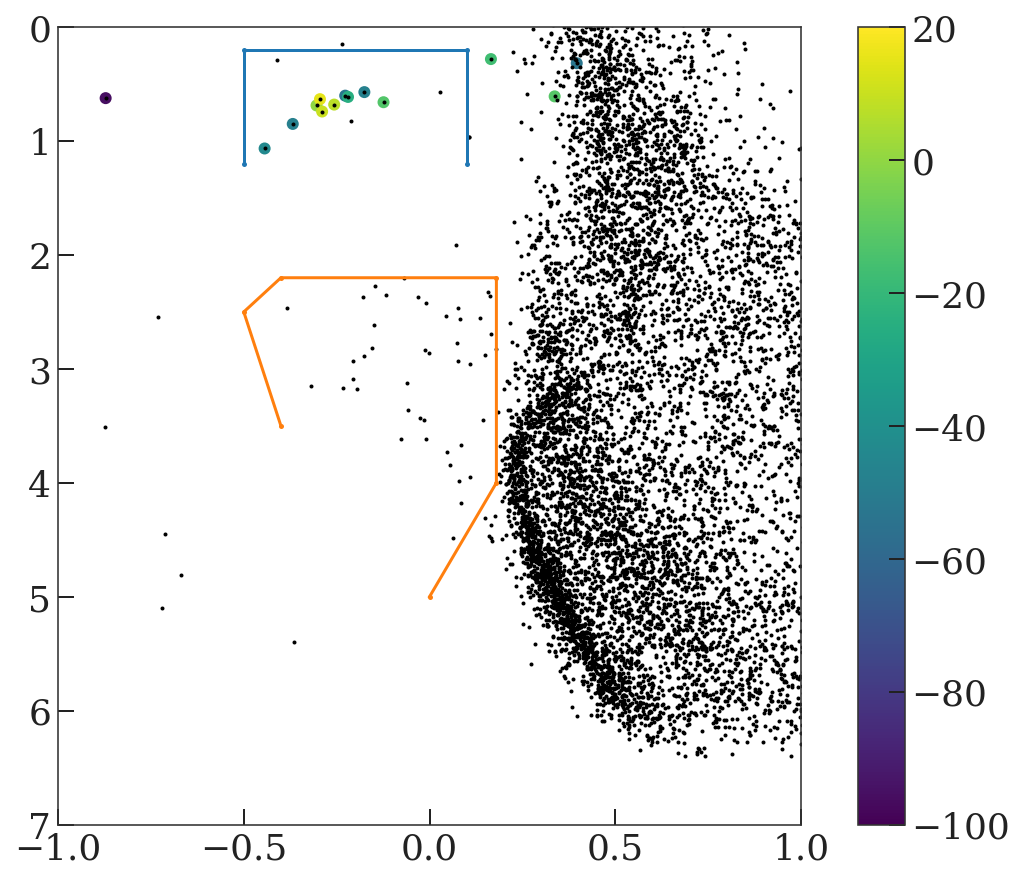

In [33]:
mask = rough_pm_mask & (sky_track_mask | spur_box_mask)

fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

ax.plot(
    gi0[mask],
    Mr0[mask], 
    marker='o',
    ms=2., 
    ls='none'
)
ax.set_xlim(-1, 1)
ax.set_ylim(7, 0)

ax.plot(bhb_nodes[:, 0], bhb_nodes[:, 1])
ax.plot(bs_nodes[:, 0], bs_nodes[:, 1])

ax.scatter(
    gi0[mask][idxr[sepr < 1*u.arcsec]],
    Mr0[mask][idxr[sepr < 1*u.arcsec]],
    # color='red'
    c=c_gd1.phi1.degree[mask][idxr[sepr < 1*u.arcsec]],
    cmap='viridis',
    vmin=-100, vmax=20
)
cs = ax.scatter(
    gi0[mask][idxb[sepb < 1*u.arcsec]],
    Mr0[mask][idxb[sepb < 1*u.arcsec]],
    # color='tab:purple'
    c=c_gd1.phi1.degree[mask][idxb[sepb < 1*u.arcsec]],
    cmap='viridis',
    vmin=-100, vmax=20
)
fig.colorbar(cs)

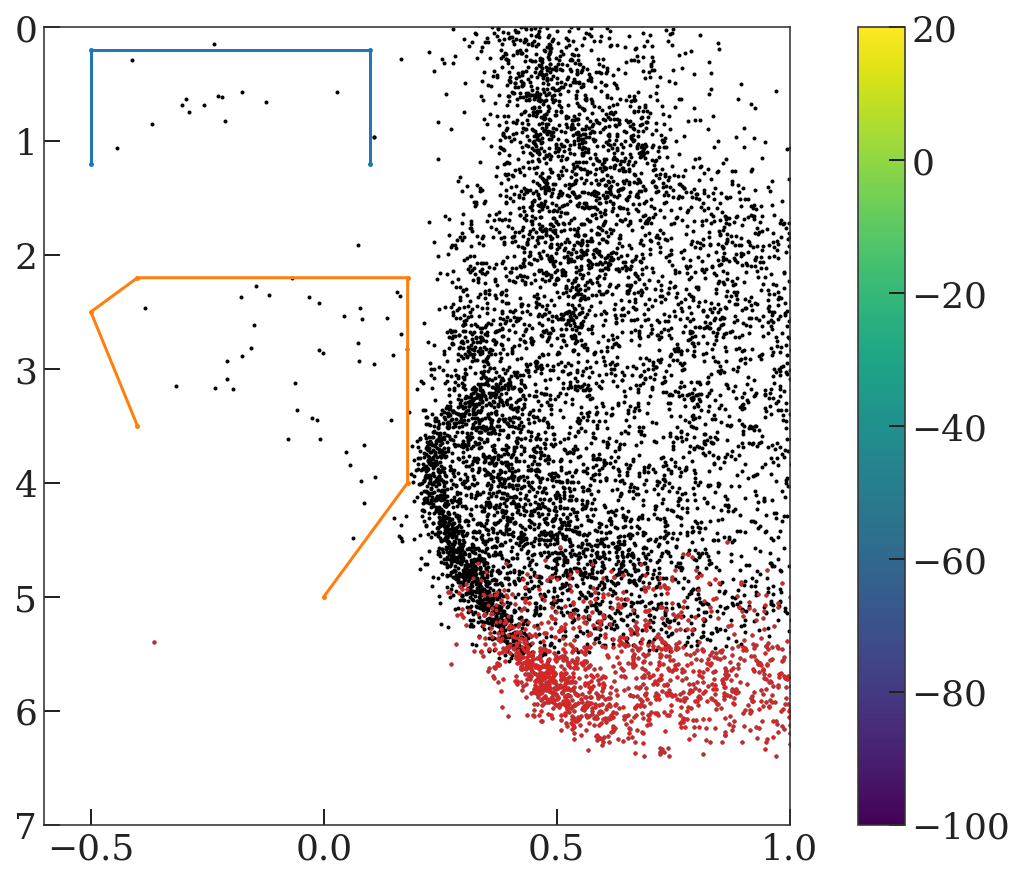

In [38]:
mask = rough_pm_mask & (sky_track_mask | spur_box_mask)

fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

ax.plot(
    gi0[mask],
    Mr0[mask], 
    marker='o',
    ms=2., 
    ls='none'
)

ax.plot(
    gi0[mask & (g.phot_g_mean_mag > 20*u.mag)],
    Mr0[mask & (g.phot_g_mean_mag > 20*u.mag)], 
    marker='o',
    ms=2., 
    ls='none',
    color='tab:red'
)

ax.set_xlim(-0.6, 1)
ax.set_ylim(7, 0)

ax.plot(bhb_nodes[:, 0], bhb_nodes[:, 1])
ax.plot(bs_nodes[:, 0], bs_nodes[:, 1])

fig.colorbar(cs)

# Stream track plots:

In [28]:
pm_cov = g.get_cov()[:, 3:5, 3:5]
pm_cov_gd1 = gc.transform_pm_cov(c, pm_cov, gc.GD1Koposov10())

(-100.0, 20.0)

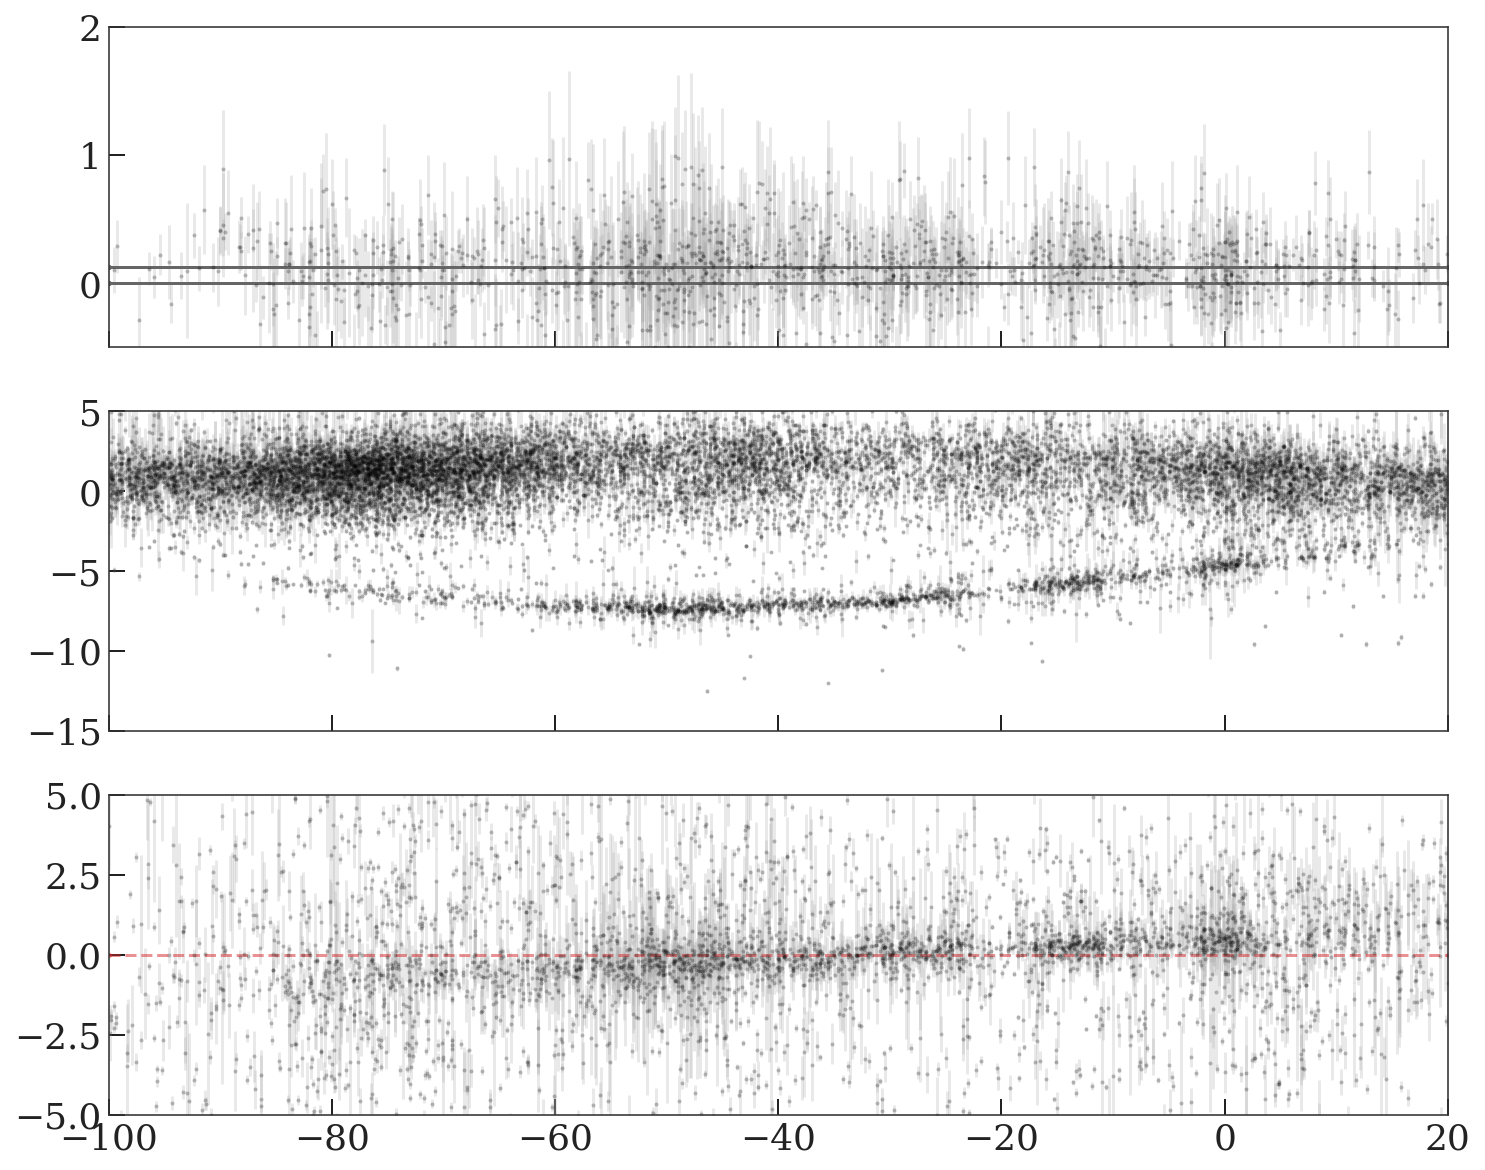

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

mask = mask_tbl['sky_track'] & mask_tbl['cmd_ms'] & mask_tbl['pm_rough'] & (g.phot_g_mean_mag.value < 20.)
axes[0].errorbar(
    g.gd1_phi1[mask], 
    g.parallax[mask].value,
    g.parallax_error[mask].value,
    ls='none',
    marker='o',
    mew=0, 
    ms=2.,
    ecolor='#aaaaaa',
    alpha=0.25
)
axes[0].axhline(1 / 8.)
axes[0].axhline(0)
axes[0].set_ylim(-0.5, 2.)

mask = mask_tbl['sky_track'] & mask_tbl['cmd_ms'] & (np.abs(c_gd1_refl.pm_phi2) < 1*u.mas/u.yr)
axes[1].errorbar(
    g.gd1_phi1[mask], 
    c_gd1_refl.pm_phi1_cosphi2.value[mask],
    np.sqrt(pm_cov_gd1[mask, 0, 0]),
    ls='none',
    marker='o',
    mew=0, 
    ms=2.,
    ecolor='#aaaaaa',
    alpha=0.25
)
axes[1].set_ylim(-15, 5)

mask = mask_tbl['sky_track'] & mask_tbl['cmd_ms'] & (c_gd1_refl.pm_phi1_cosphi2 < -2.5*u.mas/u.yr)
# galcen_frame2 = coord.Galactocentric(
#     galcen_distance=8.275 * u.kpc,
#     galcen_v_sun=[8.4, 251.8, 8.4] * u.km/u.s
# )
# c_gd1_refl2_tmp = gc.reflex_correct(c_tmp[mask].transform_to(gc.GD1Koposov10()), galcen_frame2)
axes[2].errorbar(
    g.gd1_phi1[mask], 
    c_gd1_refl.pm_phi2.value[mask],
#     c_gd1_refl2_tmp.pm_phi2.value,
    np.sqrt(pm_cov_gd1[mask, 1, 1]),
    ls='none',
    marker='o',
    mew=0, 
    ms=2.,
    ecolor='#aaaaaa',
    alpha=0.25
)
axes[2].set_ylim(-5, 5)
axes[2].axhline(0, color='tab:red', alpha=0.5, ls='--')

axes[0].set_xlim(-100, 20)